## Script to fit isochrones for ARMADA binaries

#### - We know delta mag in a few bands from speckle or WDS. We know delta mag in H/K bands from interferometry. We know total magnitudes in many bands from literature.
#### - In theory, we know distance from Hipparcos or Gaia (this is weakest point, as they are unresolved binaries!)

#### - Compare photometry to models using isochrones package

###### The python isochrones package is needed to run this notebook: https://isochrones.readthedocs.io/en/latest/
###### As suggested in the user guide, I prefer installing isochrones in a separate conda environment. Hence, this environment needs to be activated before running jupyter lab

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
import random
from astroquery.simbad import Simbad
from uncertainties import ufloat,unumpy
from uncertainties.umath import *
import pandas as pd
from tqdm import tqdm

from isochrones.mist import MIST_EvolutionTrack, MIST_Isochrone
Mist_iso = MIST_Isochrone()
Mist_evoTrack = MIST_EvolutionTrack()

%matplotlib inline

PyMultiNest not imported.  MultiNest fits will not work.


In [2]:
matplotlib.rcParams['figure.figsize'] = (8, 5)

In [3]:
## Add quantities of interest to Simbad query -- for total magnitudes
##
## This is a good first check, but for for each target we will eventually 
## want to do a deeper literature search to make sure we are using 
## all available photometry. We should record this in the spreadsheet.

Simbad.add_votable_fields('flux(U)')
Simbad.add_votable_fields('flux(B)')
Simbad.add_votable_fields('flux(V)')
Simbad.add_votable_fields('flux(G)')
Simbad.add_votable_fields('flux(R)')
Simbad.add_votable_fields('flux(I)')
Simbad.add_votable_fields('flux(J)')
Simbad.add_votable_fields('flux(H)')
Simbad.add_votable_fields('flux(K)')
Simbad.add_votable_fields('flux_error(U)')
Simbad.add_votable_fields('flux_error(B)')
Simbad.add_votable_fields('flux_error(V)')
Simbad.add_votable_fields('flux_error(G)')
Simbad.add_votable_fields('flux_error(R)')
Simbad.add_votable_fields('flux_error(I)')
Simbad.add_votable_fields('flux_error(J)')
Simbad.add_votable_fields('flux_error(H)')
Simbad.add_votable_fields('flux_error(K)')

In [4]:
## Setup paths
save_directory = '/Users/tgardner/ARMADA_isochrones/' ## path for saved files
armada_file = '/Users/tgardner/Google Drive/My Drive/ARMADA_final/full_target_list.csv' ## path to csv target file
note = 'hip' ## note for saved files (e.g. 'hip' for hipparcos distance, or 'gaia')

## First select a binary target and get info from csv file

In this part, user can specify a target and query from simbad to obtain its total apparent magnitude. With the measured flux ratio, user can split the total observed magnitude in a system to separate magnitudes of individual stars. The formula is given below.
$$\Delta M = -2.5\log_{10}(f_1/f_2)~~~\Rightarrow~~~f_1 = 10^{-0.4\Delta M}f_2$$
Let $m$ be the total apparent magnitude queried from simbad, we can calculate apparent magnitude $m_1$, $m_2$ for individual targets.
$$m_1 = m-2.5\log_{10}\frac{f_1+f_2}{f_1}$$
$$m_2 = m-2.5\log_{10}\frac{f_1+f_2}{f_2}$$
To convert everything to absolute magnitude, we subtract distance modulus from the results:
$$M_i = m_i - 5\log_{10}(d/10pc)$$
We assume no extinction, and the two stars are of equal distance to us.

Note that we will likely fit to observables (i.e. total magnitude and flux ratios)

In [5]:
target_hd = '6456'
df = pd.read_csv(armada_file,dtype=object)

## Create directory for saved files, if it doesn't already exist
directory = "%s/HD_%s/"%(save_directory,target_hd)
if not os.path.exists(directory):
    print("Creating directory")
    os.makedirs(directory)

In [6]:
idx = np.where(df['HD']==target_hd)[0][0]

distance_gaia = ufloat(float(df['Gaia_distance (pc)'][idx]),float(df['Gaia_distance_err (pc)'][idx]))
distance_hip = ufloat(float(df['HIP_distance (pc)'][idx]),float(df['HIP_distance_err (pc)'][idx]))
print("distance gaia = ",distance_gaia)
print("distance hip = ",distance_hip)


cdiff_h = ufloat(float(df['dmag_h'][idx]),float(df['dmag_h_err'][idx]))
cdiff_k = ufloat(float(df['dmag_k'][idx]),float(df['dmag_k_err'][idx]))
cdiff_i = ufloat(float(df['dmag_speckle_i'][idx]),float(df['dmag_speckle_i_err'][idx]))
cdiff_b = ufloat(float(df['dmag_speckle_b'][idx]),float(df['dmag_speckle_b_err'][idx]))
cdiff_wds = ufloat(float(df['dmag_wds_v'][idx]),float(df['dmag_wds_v_err'][idx]))

fratio_h = 10**(cdiff_h/2.5)
fratio_k = 10**(cdiff_k/2.5)
fratio_i = 10**(cdiff_i/2.5)
fratio_b = 10**(cdiff_b/2.5)
fratio_wds = 10**(cdiff_wds/2.5)

print("fratio: b_mag, wds, i_mag, h_mag, k_mag = ")
print(fratio_b,',',fratio_wds,',',fratio_i,',',fratio_h,',',fratio_k)

distance gaia =  nan+/-nan
distance hip =  84+/-5
fratio: b_mag, wds, i_mag, h_mag, k_mag = 
2.11+/-0.29 , 2.2+/-0.5 , 1.91+/-0.26 , 2.1+/-0.4 , nan+/-nan


In [7]:
## choose which distance to use -- not necessarily obvious! We may want to compare both
distance = distance_hip

In [8]:
## query total magnitudes and errors from Simbad
query = Simbad.query_object('HD %s'%target_hd)

ktot = ufloat(query['FLUX_K'][0],query['FLUX_ERROR_K'][0])
utot = ufloat(query['FLUX_U'][0],query['FLUX_ERROR_U'][0])
btot = ufloat(query['FLUX_B'][0],query['FLUX_ERROR_B'][0])
rtot = ufloat(query['FLUX_R'][0],query['FLUX_ERROR_R'][0])
itot = ufloat(query['FLUX_I'][0],query['FLUX_ERROR_I'][0])
htot = ufloat(query['FLUX_H'][0],query['FLUX_ERROR_H'][0])
jtot = ufloat(query['FLUX_J'][0],query['FLUX_ERROR_J'][0])
vtot = ufloat(query['FLUX_V'][0],query['FLUX_ERROR_V'][0])
gtot = ufloat(query['FLUX_G'][0],query['FLUX_ERROR_G'][0])

print("U,B,V,G,R,J,H,K = ")
print(utot,',',btot,',',vtot,',',gtot,',',rtot,',',jtot,',',htot,',',ktot)

U,B,V,G,R,J,H,K = 
5.260000228881836+/-nan , 5.263+/-0.014 , 5.273+/-0.009 , 5.268+/-0.006 , nan+/-nan , 5.24+/-0.05 , 5.301+/-0.021 , 5.265+/-0.027


/Users/tgardner/opt/anaconda3/envs/isochrones/lib/python3.10/site-packages/uncertainties/core.py:2801: UserWarning: Warning: converting a masked element to nan.
  self._std_dev = CallableStdDev(std_dev)
/Users/tgardner/opt/anaconda3/envs/isochrones/lib/python3.10/site-packages/uncertainties/core.py:2766: UserWarning: Warning: converting a masked element to nan.
  value = float(value)


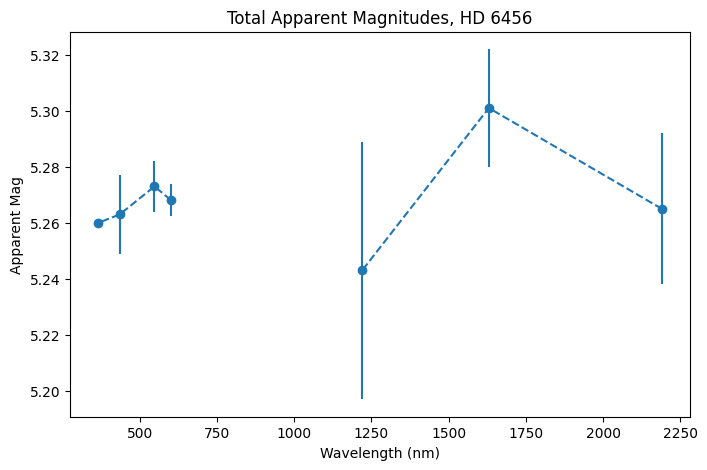

In [9]:
x = np.array([2190,1630,1220,634.9,600,547.7,435.3,365.6]) ## central wavelengths of Simbad magnitudes chosen above
y = np.array([ktot.nominal_value,htot.nominal_value,jtot.nominal_value,
              rtot.nominal_value,gtot.nominal_value,vtot.nominal_value,
              btot.nominal_value,utot.nominal_value])
yerr = np.array([ktot.std_dev,htot.std_dev,jtot.std_dev,rtot.std_dev,
                 gtot.std_dev,vtot.std_dev,btot.std_dev,utot.std_dev])

plt.title("Total Apparent Magnitudes, HD %s"%target_hd)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Apparent Mag")
plt.errorbar(x,y,yerr,fmt='o--')
plt.savefig("%s/HD_%s_%s_total_mags.pdf"%(directory,target_hd,note))
plt.show()

In [10]:
data_wave = np.array([445,551,806,1630,2190]) ## wavelengths of our speckle + interferometry data, CHECK THESE

## Compute individual magnitudes from flux ratios and total magnitudes
## Mostly for plotting. We probably won't fit to these in the end. 

k1 = -2.5*log10(10**(-ktot/2.5)/(1+10**(-cdiff_k/2.5)))
k2 = cdiff_k + k1

h1 = -2.5*log10(10**(-htot/2.5)/(1+10**(-cdiff_h/2.5)))
h2 = cdiff_h + h1

i1 = -2.5*log10(10**(-gtot/2.5)/(1+10**(-cdiff_i/2.5)))
i2 = cdiff_i + i1

v1 = -2.5*log10(10**(-vtot/2.5)/(1+10**(-cdiff_wds/2.5)))
v2 = cdiff_wds + v1

b1 = -2.5*log10(10**(-btot/2.5)/(1+10**(-cdiff_b/2.5)))
b2 = cdiff_b + b1

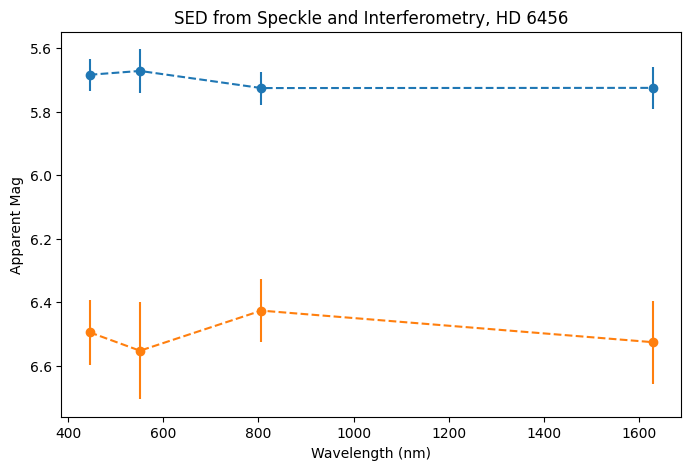

In [11]:
p1 = np.array([b1.nominal_value,v1.nominal_value,i1.nominal_value,h1.nominal_value,k1.nominal_value])
p1err = np.array([b1.std_dev,v1.std_dev,i1.std_dev,h1.std_dev,k1.std_dev])
p2 = np.array([b2.nominal_value,v2.nominal_value,i2.nominal_value,h2.nominal_value,k2.nominal_value])
p2err = np.array([b2.std_dev,v2.std_dev,i2.std_dev,h2.std_dev,k2.std_dev])

plt.title("SED from Speckle and Interferometry, HD %s"%target_hd)
plt.errorbar(data_wave,p1,p1err,fmt='o--')
plt.errorbar(data_wave,p2,p2err,fmt='o--')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Apparent Mag')
plt.gca().invert_yaxis()
plt.savefig("%s/HD_%s_%s_split_mags.pdf"%(directory,target_hd,note))
plt.show()

## Now we want to use this information to fit isochrones

#### Generate tracks of multiple ages at chosen metallicity

In [12]:
feh = -0.46 ## we will want to look up this value for each target
Av = 0.0 ## targets are nearby, so extinction should be negligible

log_age_start = 6 ## starting age
log_age_size = 0.5 ## step size
log_age_steps = 7 ## number of steps

paramList  = [np.array([log_age_start,feh])+np.array([log_age_size,0])*i for i in range(0,log_age_steps)]

isoList = [Mist_iso.isochrone(param[0],param[1]) for param in paramList] 
isoList[0].head()

,eep,age,feh,mass,initial_mass,radius,density,logTeff,Teff,logg,...,H_mag,K_mag,G_mag,BP_mag,RP_mag,W1_mag,W2_mag,W3_mag,TESS_mag,Kepler_mag
62,62.0,6.0,-0.431021,0.109384,0.109384,0.980144,0.164272,3.508683,3226.279459,3.489182,...,4.770745,4.559092,8.312007,9.724663,7.195070,4.449165,4.253865,4.122261,7.105392,8.328646
63,63.0,6.0,-0.431021,0.113531,0.113531,1.001057,0.160068,3.509973,3235.881606,3.485456,...,4.712154,4.501667,8.246036,9.648542,7.132610,4.394253,4.201994,4.071170,7.043954,8.261039
64,64.0,6.0,-0.431021,0.117668,0.117668,1.021871,0.156003,3.511253,3245.424865,3.482159,...,4.654903,4.445554,8.181301,9.573611,7.071390,4.340591,4.151356,4.021303,6.983763,8.194659
65,65.0,6.0,-0.431021,0.121788,0.121788,1.042598,0.152066,3.512516,3254.879038,3.479242,...,4.598952,4.390714,8.117808,9.499925,7.011402,4.288140,4.101901,3.972607,6.924805,8.129521
66,66.0,6.0,-0.431020,0.125898,0.125898,1.063377,0.148207,3.513761,3264.222940,3.476595,...,4.543982,4.336830,8.055299,9.427275,6.952374,4.236589,4.053315,3.924767,6.866801,8.065373


#### We need to add B, V, and I mag to the output of isochrones (H and K included by default)
#### Using bolometric correction grid to compute these model magnitudes

In [13]:
from isochrones.mist.bc import MISTBolometricCorrectionGrid
bc_grid_B = MISTBolometricCorrectionGrid(['B'])
bc_grid_V = MISTBolometricCorrectionGrid(['V'])
bc_grid_I = MISTBolometricCorrectionGrid(['I'])

In [14]:
# Check first few rows of bolometric correction grid
bc_grid_B.df.head()
#bc_grid_V.df.head()
#bc_grid_I.df.head()

B
Teff   logg [Fe/H] Av            
2500.0 -4.0 -4.0   0.00 -7.714880
                   0.05 -7.773749
                   0.10 -7.832595
                   0.15 -7.891418
                   0.20 -7.950218

In [15]:
# Calculating the bolometric correction in B band
Mbol_B = []
for i,iso in enumerate(isoList):
    Mbol_B.append(bc_grid_B.interp([iso['Teff'], iso['logg'], feh, Av]).ravel())   
B = []
for i,iso in enumerate(isoList):
    B.append(iso['Mbol'] - Mbol_B[i])
    
# Calculating the bolometric correction in V band
Mbol_V = []
for i,iso in enumerate(isoList):
    Mbol_V.append(bc_grid_V.interp([iso['Teff'], iso['logg'], feh, Av]).ravel())  
V = []
for i,iso in enumerate(isoList):
    V.append(iso['Mbol'] - Mbol_V[i])

# Calculating the bolometric correction in I band
Mbol_I = []
for i,iso in enumerate(isoList):
    Mbol_I.append(bc_grid_I.interp([iso['Teff'], iso['logg'], feh, Av]).ravel())  
I = []
for i,iso in enumerate(isoList):
    I.append(iso['Mbol'] - Mbol_I[i])
    
H = []
for iso in isoList:
    H.append(iso['H_mag'])

K = []
for iso in isoList:
    K.append(iso['K_mag'])

## Let's take a look at the HR diagram
#### No fitting at this point, but good to estimate starting value for age

In [16]:
print("Distance = ", distance, 'pc')
d_modulus = 5*log10(distance)-5
print("Distance Modulus = ", d_modulus)

Distance =  84+/-5 pc
Distance Modulus =  4.63+/-0.12


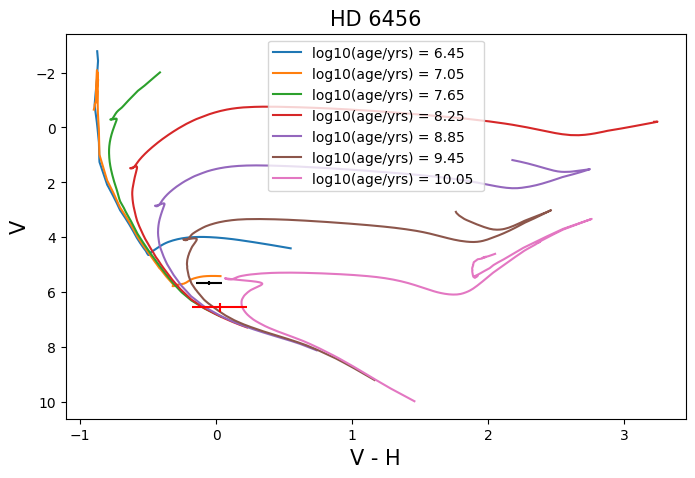

In [17]:
## change the range of plotted values in isochrones "by eye"
iso_start = 100
iso_end = 500

## Choose x/y axis. For example, V-H vs V
xval1 = v1-h1 ## component 1
yval1 = v1
xval2 = v2-h2 ## component 2
yval2 = v2

xlabel = "V - H"
ylabel = "V"

for i,iso in enumerate(isoList):
    
    ## make sure model matches data magnitudes
    modelx = V[i][iso_start:iso_end] - H[i][iso_start:iso_end]
    modely = V[i][iso_start:iso_end] + d_modulus.nominal_value
    
    plt.plot(modelx,modely,label = f"log10(age/yrs) = {6.45+0.6*i} ")

## make plot
plt.errorbar(xval1.nominal_value,yval1.nominal_value,
             xerr = xval1.std_dev, yerr = yval1.std_dev,
             color="black")
plt.errorbar(xval2.nominal_value,yval2.nominal_value,
             xerr = xval2.std_dev, yerr = yval2.std_dev,
             color="red")
        
plt.xlabel(xlabel,fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.gca().invert_yaxis()
plt.title("HD %s"%target_hd, fontsize = 15)
plt.legend()
plt.savefig("%s/HD_%s_%s_hr_diagram.pdf"%(directory,target_hd,note))
plt.show()

## Now let's do a MCMC fit for masses and age

In the fitting, the likelihood function is given by:
$$\mathcal{L} = \exp\left(-\sum_i \left(\frac{\Delta M_{i,\text{tot}}}{\sigma_{\Delta_{M_{i,\text{tot}}}}}\right)^2 + \left(\frac{\Delta (M_{i,1}-M_{i,2})}{\sigma_{\Delta (M_{i,1}-M_{i,2})}}\right)^2\right)$$

Hence, we are fitting to the total magnitudes and color differences. The model functions below returns an $\chi$-array. 

In [18]:
from isochrones import get_ichrone
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import corner
tracks = get_ichrone('mist', tracks=True, accurate=True)

In [19]:
## Objective function to be minimized for lmfit
def isochrone_model(params, TOT_mag_star, D_mag_star, TOT_mag_star_err, D_mag_star_err, d_modulus, Av):
    
    age = params['age']
    m1 = params['mass1']
    m2 = params['mass2']
    feh = params['feh']
    
    a1 = tracks.generate(m1, age, feh, return_dict=True)
    a2 = tracks.generate(m2, age, feh, return_dict=True)
    
    #if np.isnan(a1['Mbol']) or np.isnan(a2['Mbol']):
    #    return np.inf
    
    mag1_model = np.array([(a1['Mbol'] - bc_grid_B.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_I.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      a1["H_mag"]+d_modulus,
                      a1["K_mag"]+d_modulus])

    mag2_model = np.array([(a2['Mbol'] - bc_grid_B.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_I.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      a2["H_mag"]+d_modulus,
                      a2["K_mag"]+d_modulus])

    D_mag_model = mag2_model - mag1_model
    TOT_mag_model = -2.5*np.log10(10**(-0.4*mag1_model)+10**(-0.4*mag2_model))
  
    diff1 = (D_mag_star - D_mag_model) / D_mag_star_err
    diff2 = (TOT_mag_star - TOT_mag_model) / TOT_mag_star_err
    
    #print(age.value, m1.value, m2.value,diff1,diff2)

    return np.concatenate([diff1,diff2])

In [20]:
## Objective function to be minimized for lmfit
def isochrone_model_v2(params, TOT_mag_star, D_mag_star, TOT_mag_star_err, D_mag_star_err, d_modulus, Av):
    
    age = params['age']
    m1 = params['mass1']
    m2 = params['mass2']
    feh = params['feh']

    
    a1 = tracks.generate(m1, age, feh, return_dict=True)
    a2 = tracks.generate(m2, age, feh, return_dict=True)
    
    #if np.isnan(a1['Mbol']) or np.isnan(a2['Mbol']):
    #    return np.inf
    
    mag1_model = np.array([(a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_I.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      a1["H_mag"]+d_modulus,
                      a1["K_mag"]+d_modulus])

    mag2_model = np.array([(a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_I.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      a2["H_mag"]+d_modulus,
                      a2["K_mag"]+d_modulus])

    D_mag_model = mag2_model - mag1_model
    
  
    diff1 = (D_mag_star - D_mag_model) / D_mag_star_err
    
    ## Bessel_U, Bessel_B, Bessel_V, Bessel_R, Gaia_G, Bessel_I, SDSS_z, 2MASS_J, 2MASS_H, 2MASS_K
    Wavelengths = np.array([365, 445, 551, 658, 673, 806, 905, 1250, 1650, 2150])

    mag1_model = np.array([(a1['Mbol'] - bc_grid_U.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                           (a1['Mbol'] - bc_grid_B.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_R.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      a1["G_mag"]+d_modulus,  
                      (a1['Mbol'] - bc_grid_I.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_J.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      a1["H_mag"]+d_modulus,
                      a1["K_mag"]+d_modulus])

    mag2_model = np.array([(a2['Mbol'] - bc_grid_U.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                           (a2['Mbol'] - bc_grid_B.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_R.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      a2["G_mag"]+d_modulus,  
                      (a2['Mbol'] - bc_grid_I.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_J.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      a2["H_mag"]+d_modulus,
                      a2["K_mag"]+d_modulus])

    TOT_mag_model = -2.5*np.log10(10**(-0.4*mag1_model)+10**(-0.4*mag2_model))

    diff2 = (TOT_mag_star - TOT_mag_model) / TOT_mag_star_err
    # print(np.concatenate([diff1,diff2]).size)

    return np.concatenate([diff1,diff2])

#### Important note: If the age is too high for a given mass, the model photometry will return all nan (massive stars have shorter lifetimes). This can kill the fitting. 

In [21]:
#max_mass = 2.3 ## choose a maximum mass to fit for, you then need to set an appropriate maximum age!
#min_feh = 0
#max_feh = 0

#age_test = np.linspace(6,10,100)
#for tt in age_test:
#    a1 = tracks.generate(max_mass, tt, min_feh, return_dict=True)
#    if np.isnan(a1['Mbol']):
#        print("Max log(age) = %s, for mass = %s Msun"%(tt, max_mass))
#        max_age = tt
#        break

In [22]:
## if you want to set a lower max age:
#max_age = 8.26

In [23]:
## Choose observables for fitting
TOT_Mag = np.array([btot, vtot, gtot, htot, ktot])
#TOT_Mag = np.array([utot, btot, vtot, rtot, gtot, itot, jtot, htot, ktot])
DiffM = np.array([cdiff_b, cdiff_wds, cdiff_i, cdiff_h, cdiff_k])

In [26]:
## Explore a grid of chi2 over age -- NOTE: THIS MIGHT FAIL AT SOME AGES!
## You can still run the next cell to look at the progress until it failed (or you can tweak age grid)
chi2_grid = []
ages = []
age_grid = np.linspace(6,10,100)
for aa in tqdm(age_grid):
    params = Parameters()
    params.add('age',   value= aa, vary=False)
    params.add('mass1', value= 1, min=0)#, max=max_mass)
    params.add('mass2', value= 0.5, min=0)#, max=max_mass)
    params.add('feh', value = -0.46, vary=False)#min=-0.5, max=0.5)

    minner = Minimizer(isochrone_model, params, fcn_args=(unumpy.nominal_values(TOT_Mag), unumpy.nominal_values(DiffM), 
                                                          unumpy.std_devs(TOT_Mag), unumpy.std_devs(DiffM), 
                                                          d_modulus.nominal_value, Av),
                       nan_policy='omit')
    result = minner.minimize()
    chi2_grid.append(result.redchi)
    ages.append(aa)

 77%|█████████████████████████████████████████████████████████████████████████████████████████▎                          | 77/100 [00:01<00:00, 43.83it/s]


ValueError: The array returned by a function changed size between calls

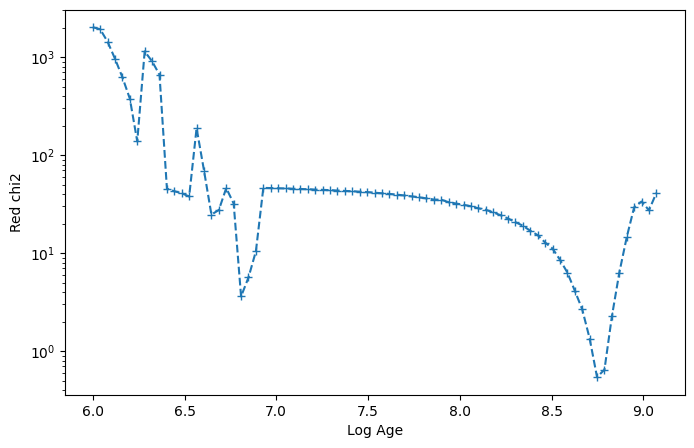

In [27]:
plt.plot(ages,chi2_grid,'+--')
plt.xlabel('Log Age')
plt.ylabel('Red chi2')
plt.yscale('log')
plt.show()

In [29]:
## start with a chi2 fit (this does not always work)

## NOTE --> Since isochrones has a fixed age grid, the fitting currently fails to optimize this parameter
## We can search age on a grid, or change the default step size for the parameter

params = Parameters()
params.add('age',   value= 8, min=6, max=10)
params.add('mass1', value= 2, min=0)#, max=max_mass)
params.add('mass2', value= 1, min=0)#, max=max_mass)
params.add('feh', value = -0.46, vary=False)#min=-0.5, max=0.5)

minner = Minimizer(isochrone_model, params, fcn_args=(unumpy.nominal_values(TOT_Mag), unumpy.nominal_values(DiffM), 
                                                      unumpy.std_devs(TOT_Mag), unumpy.std_devs(DiffM), 
                                                      d_modulus.nominal_value, Av),
                   nan_policy='omit')
result = minner.minimize()
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 9
    # variables        = 3
    chi-square         = 222.193567
    reduced chi-square = 37.0322612
    Akaike info crit   = 34.8569191
    Bayesian info crit = 35.4485929
##  Warning: uncertainties could not be estimated:
    age:    at initial value
[[Variables]]
    age:    8.00000000 (init = 8)
    mass1:  2.54685914 (init = 2)
    mass2:  1.91524260 (init = 1)
    feh:   -0.46 (fixed)


In [30]:
## Setup MCMC fit
emcee_params = result.params.copy()
nwalkers = 2*len(emcee_params)
steps = 10000
burn = 1000
thin = 100

In [31]:
emcee_params

name,value,initial value,min,max,vary
age,8.00000000,8,6.00000000,10.0000000,True
mass1,2.54685914,2,0.00000000,inf,True
mass2,1.91524260,1,0.00000000,inf,True
feh,-0.46000000,-0.46,-inf,inf,False


In [32]:
## Do MCMC fit (this cell could take some time, depending on steps)
minner = Minimizer(isochrone_model, emcee_params, fcn_args=(unumpy.nominal_values(TOT_Mag),
                                                            unumpy.nominal_values(DiffM),
                                                            unumpy.std_devs(TOT_Mag),
                                                            unumpy.std_devs(DiffM),
                                                            d_modulus.nominal_value, Av),
                   nan_policy='omit')
result = minner.minimize(method='emcee',steps=steps,burn=burn,thin=thin,nwalkers=nwalkers)
print(report_fit(result))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 272.57it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 80000
    # data points      = 9
    # variables        = 3
    chi-square         = 3.25547225
    reduced chi-square = 0.54257871
    Akaike info crit   = -3.15198506
    Bayesian info crit = -2.56031132
[[Variables]]
    age:    8.76160315 +/- 0.01984601 (0.23%) (init = 8)
    mass1:  2.03763531 +/- 0.02159156 (1.06%) (init = 2.546859)
    mass2:  1.72234727 +/- 0.02568609 (1.49%) (init = 1.915243)
    feh:   -0.46 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(age, mass1)   = -0.867
    C(mass1, mass2) = -0.304
    C(age, mass2)   = -0.192
None


#### Now let's plot some MCMC outputs
##### Need to make more plots to check convergence, etc

In [33]:
chains = result.flatchain

## save chains (so we don't need to run large ones again)
print(chains.shape)
np.save("%s/HD_%s_%s_chains.npy"%(directory,target_hd,note),chains)

(720, 3)


In [34]:
## load chains -- NOTE: Could start from here if a run has already been completed
chains = np.load("%s/HD_%s_%s_chains.npy"%(directory,target_hd,note))

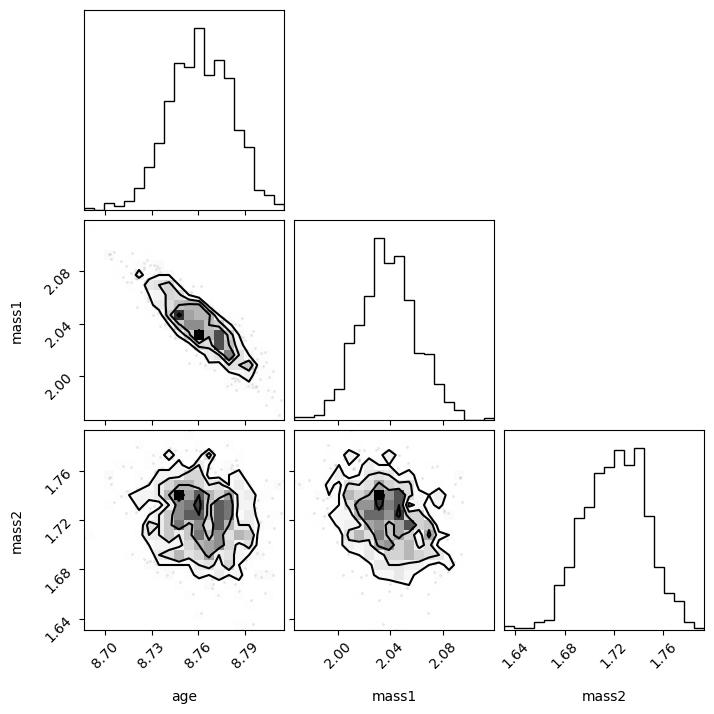

In [35]:
try:
    emcee_plot = corner.corner(chains,labels=result.var_names)
    plt.savefig('%s/HD_%s_%s_corner.pdf'%(directory,target_hd,note))
except:
    print(result.var_names)
    emcee_plot = corner.corner(chains)
    plt.savefig('%s/HD_%s_%s_corner.pdf'%(directory,target_hd,note))

#### Compute best model to make plots

In [36]:
age_chain = chains[:,0]
mass1_chain = chains[:,1]
mass2_chain = chains[:,2]

age_best = np.mean(age_chain)
mass1_best = np.mean(mass1_chain)
mass2_best = np.mean(mass2_chain)

age_err = np.std(age_chain)
mass1_err = np.std(mass1_chain)
mass2_err = np.std(mass2_chain)

In [37]:
age = ufloat(age_best,age_err)
mass1 = ufloat(mass1_best,mass1_err)
mass2 = ufloat(mass2_best,mass2_err)

In [38]:
print('Log Age = ', age)
print('M1 (solar) = ', mass1)
print('M2 (solar) = ', mass2)
print('Msum (solar) = ', mass1+mass2)

Log Age =  8.761+/-0.020
M1 (solar) =  2.038+/-0.022
M2 (solar) =  1.721+/-0.025
Msum (solar) =  3.759+/-0.033


In [39]:
a1_best = tracks.generate(mass1_best, age_best, feh, return_dict=True)
a2_best = tracks.generate(mass2_best, age_best, feh, return_dict=True)
    
#if np.isnan(a1['Mbol']) or np.isnan(a2['Mbol']):
#    return np.inf
    
model1 = np.array([(a1_best['Mbol'] - bc_grid_B.interp([a1_best['Teff'], a1_best['logg'], feh, Av ])+d_modulus.nominal_value)[0],
                  (a1_best['Mbol'] - bc_grid_V.interp([a1_best['Teff'], a1_best['logg'], feh, Av ])+d_modulus.nominal_value)[0],
                  (a1_best['Mbol'] - bc_grid_I.interp([a1_best['Teff'], a1_best['logg'], feh, Av ])+d_modulus.nominal_value)[0],
                  a1_best["H_mag"]+d_modulus.nominal_value,
                  a1_best["K_mag"]+d_modulus.nominal_value])

model2 = np.array([(a2_best['Mbol'] - bc_grid_B.interp([a2_best['Teff'], a2_best['logg'], feh, Av ])+d_modulus.nominal_value)[0],
                  (a2_best['Mbol'] - bc_grid_V.interp([a2_best['Teff'], a2_best['logg'], feh, Av ])+d_modulus.nominal_value)[0],
                  (a2_best['Mbol'] - bc_grid_I.interp([a2_best['Teff'], a2_best['logg'], feh, Av ])+d_modulus.nominal_value)[0],
                  a2_best["H_mag"]+d_modulus.nominal_value,
                  a2_best["K_mag"]+d_modulus.nominal_value])

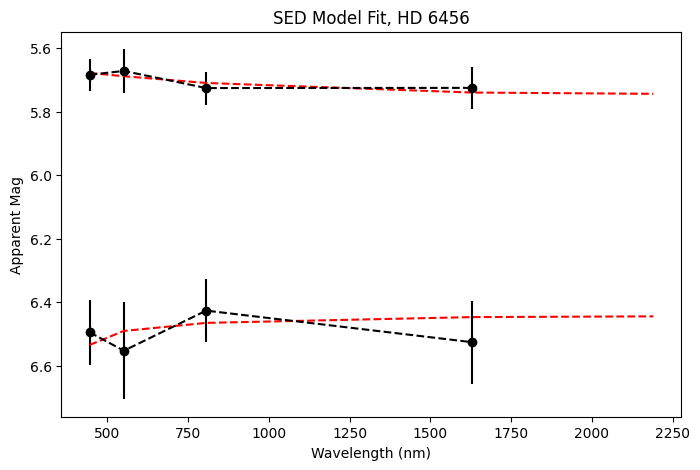

In [40]:
## SED plot with best fit
plt.title("SED Model Fit, HD %s"%target_hd)
plt.errorbar(data_wave,p1,p1err,fmt='o--',color='black')
plt.errorbar(data_wave,p2,p2err,fmt='o--',color='black')

plt.plot(data_wave,model1,'--',color='red')
plt.plot(data_wave,model2,'--',color='red')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Apparent Mag')
plt.gca().invert_yaxis()
plt.savefig("%s/HD_%s_%s_sed_fit.pdf"%(directory,target_hd,note))
plt.show()